# Assignment 2: CNN

#### Option 1: Paper Reading
- Pick one of the following papers, understand its key ideas, and replicate the experiments using the datasets described in the paper or your own dataset.
    - Convolutional Neural Network Architectures for Matching Natural Language Sentences, https://arxiv.org/pdf/1503.03244.pdf
    - Matching Networks for One Shot Learning , https://arxiv.org/pdf/1606.04080v2.pdf
    - Prototypical Networks for Few-shot Learning, https://arxiv.org/pdf/1703.05175v2.pdf
- Requirements:
    - Write a report summarizing the key idea, your experiment results, and your analysis and critique
    - Give a 5-10 min oral presentation in class

#### Option 2: Siamese CNN 

In this Assignment, let's use CNN to detect duplicate sentences. Two datasets have been prepared for you: train.csv and test.csv. Both files are in the following format

|question1 | question2 |is_duplicate|
|------|------|-------|
|How do you take a screenshot on a Mac laptop?|  How do I take a screenshot on my MacBook Pro? ...|   1 |
|Is the US election rigged?|  Was the US election rigged?|   1 |
|How scary is it to drive on the road to Hana g...|  Do I need a four-wheel-drive car to drive all ...	|  0  |
|...|...| ...|

Follow the instructions below to clasify the sentence pairs in the training dataset and then test the model using test.csv.

#### 1. Define a **class** called "text_processor" to preporcess text:
- first create **"\_\_init\_\_"** function:
    - set the *class attributes*: MAX_SEN_LEN (max sentence length) and MAX_WORDS (max number of words in corpus). You'll need to explore the dataset to set these two parameters properly
    - initialize a tokenizer with parameter num_words = MAX_WORDS and set the tokenizer object as a *class object*
    - fit the tokenizer using the training sentence pairs (i.e. method "*fit_on_texts*")
- create a function **"generate_seq"** which does the following:
    - take a list of sentences as an input 
    - generates padded sequences from the sentences using the class tokenizer object define above
    - retrun the padding sequences

In [2]:
# Add import
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk,string
from gensim import corpora
from keras.models import Model


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
 

# fix random number
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(231)

Using TensorFlow backend.
D:\ProgramData\Anaconda3\envs\03_ten1131_keras231\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\03_ten1131_keras231\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\03_ten1131_keras231\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Pr

In [2]:
# Define text_preprocessor class
class text_preprocessor(object):
    
    # define __init__ function    
    def __init__(self, max_sen_len, max_words, docs):
        
        # add your code here
        # set sentence/document length
        self.max_sen_len = max_sen_len
        
        # set the maximum number of words to be used
        #max_word will define the max value of tokenizer
        self.max_words = max_words
        
        #set data to self.doc
        self.docs = docs
        #print(self.docs.head()) #success
        
        #self.word = tokenizer.word_index
        #these two line create dictornary, give index to each words
        
        self.tokenizer = Tokenizer(num_words=self.max_words)
        tokenizer.fit_on_texts(self.docs)
    # define generate_seq function 
    def generate_seq(self, docs):
        
        sequences = None
        
        # add your code here
        # convert each document to a list of word index as a sequence
        # get a Keras tokenizer
        # https://keras.io/preprocessing/text/
        #don't put tokenize in here
        #if you tokenize here, you will create a brand new dictonary/volcapbulaer
        tokenizer = Tokenizer(num_words=self.max_words)
        
        #Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. 
        #So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 
        #it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. 
        #So lower integer means more frequent word (often the first few are stop words because they appear a lot).
        
        tokenizer.fit_on_texts(self.docs)
        #Transforms each text in texts to a sequence of integers. So it basically takes each word in the text 
        #and replaces it with its corresponding integer value from the word_index dictionary. 
        #Nothing more, nothing less, certainly no magic involved.
        
        sequences = tokenizer.texts_to_sequences(self.docs)
        
        #this is final result, it's a 
        padded_sequences = pad_sequences(sequences, \
                                 maxlen=self.max_sen_len, \
                                 padding='post', \
                                 truncating='post')

        word_index = tokenizer.word_index
        word_count = tokenizer.word_counts
        #print('Number of Unique Tokens',len(word_index))
        #print(word_count)
        #print(padded_sequences.shape)
        #print(type(padded_sequences))
        self.word = tokenizer.word_index
        
        return padded_sequences
    

#### 2. Create a function "cnn_model" to define a CNN model as follows:
- take parameters: FILTER_SIZERS (a list of Conv1D filter sizes), NUM_FILTERS (the number of filters), MAX_WORDS, MAX_SEN_LEN, and EMBEDDING_DIM (dimision of word vectors)
- define a CNN model with **Conv1D** using the specifified FILTER_SIZERS and NUM_FILTERS. For example, if FILTER_SIZERS=[1,2,3] and NUM_FILTERS=64, your model may look like the figure below.
- return this CNN model

<img src='04_Images/12_cnn_model.png' width='50%'>

In [3]:
# define CNN model
def cnn_model(EMBEDDING_DIM, \
              # word vector dimension
              FILTER_SIZES,\
              # filter sizes as a list
              MAX_WORDS, \
              # total number of words
              MAX_SEN_LEN, \
              # max words in a doc
              #NAME = 'cnn',\
              NUM_FILTERS\
              #add input layer from outside
              #outside_input
              ):            
    
    model = None
    
    # add your code here
    # define input layer, where a sentence represented as
    # 1 dimension array with integers
    main_input = Input(shape=(MAX_SEN_LEN,), dtype='int32', name='main_input')
    
    # define the embedding layer
    # input_dim is the size of all words +1,because we will use wide convolution, we add zero before first input layer
    # where 1 is for the padding symbol
    # output_dim is the word vector dimension
    # input_length is the max. length of a document
    # input to embedding layer is the "main_input" layer
    embed_1 = Embedding(input_dim=MAX_WORDS+1, \
                    output_dim=EMBEDDING_DIM, \
                    input_length=MAX_SEN_LEN,\
                    name='embedding')(main_input)  
    

    # define 1D convolution layer
    # 64 filters are used
    # a filter slides through each word (kernel_size=1)
    # input to this layer is the embedding layer
    conv1d_1= Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_SIZES[0], \
                     name='conv_unigram',\
                     activation='relu')(embed_1)

    # define a 1-dimension MaxPooling 
    # to take the output of the previous convolution layer
    # the convolution layer produce 
    # MAX_SEN_LEN-1+1 values as ouput (???)
    pool_1 = MaxPooling1D(MAX_SEN_LEN-1+1, \
                          name='pool_unigram')(conv1d_1)

    # The pooling layer creates output 
    # in the size of (# of sample, 1, 64)  
    # remove one dimension since the size is 1
    flat_1 = Flatten(name='flat_unigram')(pool_1)

    
    #***********************************************************************************#
    
    
    # following the same logic to define 
    # filters for bigram
    conv1d_2= Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_SIZES[1], \
                     name='conv_bigram',\
                     activation='relu')(embed_1)
    pool_2 = MaxPooling1D(MAX_SEN_LEN-2+1, name='pool_bigram')(conv1d_2)
    flat_2 = Flatten(name='flat_bigram')(pool_2)

    
    
    #***********************************************************************************#
        
    # filters for trigram
    conv1d_3= Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_SIZES[2], \
                     name='conv_trigram',activation='relu')(embed_1)
    pool_3 = MaxPooling1D(MAX_SEN_LEN-3+1, name='pool_trigram')(conv1d_3)
    flat_3 = Flatten(name='flat_trigram')(pool_3)

    # Concatenate flattened output
    z=Concatenate(name='concate')([flat_1, flat_2, flat_3])

    # create the model with input layer
    # and the output layer
    model = Model(inputs=main_input, outputs=z)
    #model.summary()
    
    return model

#### 3. Define three architecutres as described below. You may add appropriate regularizers in each model:
- Model A: Use one CNN described above to process each question **without any parameter sharing**. Concatenate features extracted from both CNNs and then use a dense layer to predict the output
- Model B: Use a **shared** CNN to process both questions. Concatenate features extracted from the CNN and then use a dense layer to predict the output
- Model C: Use a shared CNN to process both questions. Then take the **absolute difference** between the feature vectors extracted from the CNN (hint, use keras "Lambda" layer), and connect the difference to a dense layer to predict the output
- Model D (**Bonus**): You can come up with your own architecture as long as it can outperform the above models


##### Reference architectures

| Model A | Model B   | Model C |
|:------:|:------:|:---------:|
|   <img src="04_Images/09_model_a.png"/>| <img src="04_Images/10_model_b.png" />| <img src="04_Images/11_model_c.png"/> |



In [4]:
# define Model A
def model_A(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS, MAX_SEN_LEN, NUM_FILTERS,):
    
    
    model = None
    
    # add your code here
    q1_input = Input(shape=(MAX_SEN_LEN,), dtype='int32', name='q1_input')
    q2_input = Input(shape=(MAX_SEN_LEN,), dtype='int32', name='q2_input')
    
    
    left_cnn = cnn_model(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS, MAX_SEN_LEN, NUM_FILTERS)
    left = left_cnn(q1_input)
    #print(type(left_cnn))
    right_cnn = cnn_model(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS, MAX_SEN_LEN, NUM_FILTERS)
    right = right_cnn(q2_input)
    #print(type(right_cnn))
    con_layer=Concatenate(name='concate')([left, right])
    
    # Create a dropout layer
    # In each iteration only 50% units are turned on
    drop_1=Dropout(rate=0.5, name='dropout')(con_layer)

    # Create a dense layer
    dense_1 = Dense(192, activation='relu', name='dense')(drop_1)
    # Create the output layer
    preds = Dense(1, activation='sigmoid', name='output')(dense_1)
    model = Model(inputs=[q1_input,q2_input], outputs=preds)
    #model.summary()
    
    
    return model

In [5]:
# define Model B

def model_B(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS, MAX_SEN_LEN, NUM_FILTERS,):
    
    model = None
    
    # add your code here
    q1_input = Input(shape=(MAX_SEN_LEN,), dtype='int32', name='q1_input')
    q2_input = Input(shape=(MAX_SEN_LEN,), dtype='int32', name='q2_input')
    
    
    cnn = cnn_model(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS, MAX_SEN_LEN, NUM_FILTERS)

    con_layer=Concatenate(name='concate')([cnn(q1_input), cnn(q2_input)])
    
    # Create a dropout layer
    # In each iteration only 50% units are turned on
    drop_1=Dropout(rate=0.5, name='dropout')(con_layer)

    # Create a dense layer
    dense_1 = Dense(192, activation='relu', name='dense')(drop_1)
    # Create the output layer
    preds = Dense(1, activation='sigmoid', name='output')(dense_1)
    model = Model(inputs=[q1_input,q2_input], outputs=preds)
    model.summary()
    
    return model



In [6]:
# define Model C

def model_C(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS, MAX_SEN_LEN, NUM_FILTERS,):
    from keras.layers import Lambda
    from keras import backend as K
#     from keras.utils import plot_model
#     import pydot
    
    model = None
    
    # add your code here
    q1_input = Input(shape=(MAX_SEN_LEN,), dtype='int32', name='q1_input')
    q2_input = Input(shape=(MAX_SEN_LEN,), dtype='int32', name='q2_input')
    
    
    cnn = cnn_model(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS, MAX_SEN_LEN, NUM_FILTERS)

    #con_layer=Concatenate(name='concate')([cnn(q1_input), cnn(q2_input)])
    
    Diff = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))([cnn(q1_input), cnn(q2_input)]) 
    # Create a dropout layer
    # In each iteration only 50% units are turned on
    drop_1=Dropout(rate=0.5, name='dropout')(Diff)

    # Create a dense layer
    dense_1 = Dense(192, activation='relu', name='dense')(drop_1)
    # Create the output layer
    preds = Dense(1, activation='sigmoid', name='output')(dense_1)
    model = Model(inputs=[q1_input,q2_input], outputs=preds)
    model.summary()
   
    #plot_model(model, to_file='04_Images/model.png')
    return model

#### 4. Define a function "train_model" to:
- Train a model provided as an input parameter
- Use appropriate techniques to ensure you don't overfit the model
- Plot training history to make sure your model is reasonable good
- Using the testing dataset, calculate precision, recall, and F-1 score of each class (assuming 0.5 probabbility threshould), and also report AUC score.


In [7]:
# define train_model function

def train_model(model, \
                q1_train, q2_train, y_train, \
                q1_val, q2_val, y_val, \
                q1_test, q2_test, y_test, \
                BATCH_SIZE, \
                NUM_EPOCHES
               ):
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    
    # compile and train model
    # process test dataset
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", \
              metrics=["accuracy"]
                 )
    
    #BATCH_SIZE = 64
    #NUM_EPOCHES = 10

    # fit the model and save fitting history to "training"
    training=model.fit([q1_train, q2_train],y_train, \
                   batch_size=BATCH_SIZE, \
                   epochs=NUM_EPOCHES,\
                   validation_data=[[q1_val, q2_val],y_val], \
                   #verbose=2
                        )
    
    # plot training history
    # the fitting history is saved as dictionary
    # covert the dictionary to dataframe
    df_hist=pd.DataFrame.from_dict(training.history)
    df_hist.columns=[ "val_loss", "val_acc", "train_loss","train_acc"]
    df_hist.index.name='epoch'
    print(df_hist)

    # plot training history
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));

    df_hist[["train_acc", "val_acc"]].plot(ax=axes[0]);
    df_hist[["train_loss", "val_loss"]].plot(ax=axes[1]);
    plt.show();
    
    # predict testing samples
    y_pred = model.predict([q1_test,q2_test])

    
    
    
    # print classfication report
    
    print(classification_report(y_test, y_pred[:] > 0.5))
    
    # calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    print('AUC: {:.2f}'.format(auc(fpr, tpr)))

    plt.figure(figsize = (15, 7))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Logistic')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'No skill')
    plt.title('AUC of Siamese Network Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.show();
    
    # add your code here
    
    

#### 5. Call the function "train_model" to get the performance of each model. Show your analysis as markdowns on the following:
- How did you choose the hyperparaters: FILTER_SIZES,NUM_FILTERS, MAX_SEN_LEN, MAX_WORDS, EMBEDDING_DIM
- Analyze each architecture to understand its pros and cons
- Which architecture is the most effective and why is it effective for this classification task?
- What regularizers did you use and why did it work?
- What features do you think CNN can successfully extract? What kind of useful features could be missed by CNN?

In [4]:
# Train and test each model
if __name__ == "__main__":  
 
    #read data
    #our train.csv have three column ,[questin1] and [question2] are string sentence. Next step we should transfer sentence into vector
    df_train = pd.read_csv('03_data/21_train.csv')
    df_test = pd.read_csv('03_data/22_test.csv')
    
    X_train, X_val, Y_train, Y_val = train_test_split(\
                        df_train.iloc[:,:2], df_train['is_duplicate'],\
                        test_size=0.3, random_state=1)
    # Set hyper parameters
    #maybe means, first is unigram(kernel_size=1), second is bigram(kernel_size=2), third is trigram(kernel_size=3)
    FILTER_SIZES = [1, 2, 3]
    
    #how manny feature maps to extract
    NUM_FILTERS = 64
    
    #I think this parameter is saame as MAX_SEN_LEN
    #MAX_DOC_LEN = 500
    
    #for these two column sentence, the lengthist is 105 words in single sentence
    MAX_SEN_LEN = len(df_train['question1'].max())
    
    #this is definnation of tokenzier max token value, smaller and less feature, and greater value will get more features
    #typical we setup 10000 to adapat requirement of word feature extract
    MAX_WORDS = 10000
    
    #the output dimention of embedding input layers 
    EMBEDDING_DIM = 200
    
    BATCH_SIZE = 256
    
    NUM_EPOCHES = 5
    
    #try to find the max length of these two questions set
    print(len(df_train['question1'].max()))
    

    
    data1_test = df_test['question1']
    data2_test = df_test['question2']
    Y_test = df_test['is_duplicate']
    
    
    seq_1 = text_preprocessor(MAX_SEN_LEN, MAX_WORDS, X_train['question1'])
    data1_train= seq_1.generate_seq(X_train['question1'])
    
    seq_2 = text_preprocessor(MAX_SEN_LEN, MAX_WORDS, X_train['question2'])
    data2_train= seq_2.generate_seq(X_train['question2'])
    
    seq_3 = text_preprocessor(MAX_SEN_LEN, MAX_WORDS, X_val['question1'])
    data1_val= seq_3.generate_seq(X_val['question1'])
    
    seq_4 = text_preprocessor(MAX_SEN_LEN, MAX_WORDS, X_val['question2'])
    data2_val = seq_4.generate_seq(X_val['question2'])
    
    seq_5 = text_preprocessor(MAX_SEN_LEN, MAX_WORDS, df_test['question1'])
    data1_test = seq_5.generate_seq(df_test['question1'])
    
    seq_6 = text_preprocessor(MAX_SEN_LEN, MAX_WORDS, df_test['question2'])
    data2_test = seq_6.generate_seq(df_test['question2'])
    
    #print(type(data_1))
    
    
    #print(q1_train)
    #print(q1_train.shape)
   
    # train and test model A/B/C
    a= model_A(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS,MAX_SEN_LEN,NUM_FILTERS)
    b= model_B(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS,MAX_SEN_LEN,NUM_FILTERS)
    c= model_C(EMBEDDING_DIM, FILTER_SIZES,MAX_WORDS,MAX_SEN_LEN,NUM_FILTERS)


    train_model(a, \
                data1_train, data2_train,Y_train, \
                data1_val, data2_val,Y_val, \
                data1_test, data2_test,Y_test, \
                BATCH_SIZE, \
                NUM_EPOCHES
               )


    model=None


    train_model(b, \
                data1_train, data2_train,Y_train, \
                data1_val, data2_val,Y_val, \
                data1_test, data2_test,Y_test, \
                BATCH_SIZE, \
                NUM_EPOCHES
               )
    
    model=None
    train_model(c, \
                data1_train, data2_train,Y_train, \
                data1_val, data2_val,Y_val, \
                data1_test, data2_test,Y_test, \
                BATCH_SIZE, \
                NUM_EPOCHES
               )
    

    
    # add your code here

105


NameError: name 'text_preprocessor' is not defined

6. Hyperparameter choose and answers

word frequency: 
         freq
android    57
phone      83
is       3347
best      851
up         97
to       2493
range      19
of       1984
15000       5
i        2498
   word_freq  count   percent    cumsum
0          1   6338  0.527683  0.527683
1          2   1878  0.156357  0.684040
2          3    875  0.072850  0.756890
3          4    538  0.044792  0.801682
4          5    390  0.032470  0.834152


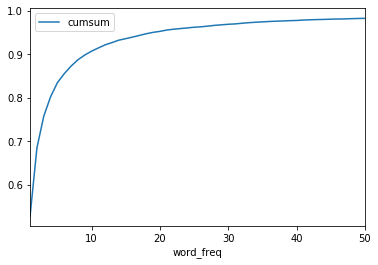

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

MAX_NB_WORDS =10000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_train["question1"])


df_count=pd.DataFrame.from_dict(tokenizer.word_counts, \
                          orient="index")
df_count.columns=['freq']
print("word frequency: ")
print(df_count.head(10))

# get histogram of word count
df_count=df_count['freq'].value_counts().reset_index()
df_count.columns=['word_freq','count']

# sort by word_freq
df_count=df_count.sort_values(by='word_freq')

# convert absolute counts to precentage
df_count['percent']=df_count['count']/len(tokenizer.word_counts)
# get cumulative percentage
df_count['cumsum']=df_count['percent'].cumsum()

print(df_count.head())

df_count.iloc[0:50].plot(x='word_freq', y='cumsum');

plt.show();


<br>

<br>

<br>

- Q:How did you choose the hyperparaters: FILTER_SIZES,NUM_FILTERS, MAX_SEN_LEN, MAX_WORDS, EMBEDDING_DIM
- A:FILTER_SIZES is the filter matrix-grim, in this problem we chouse[1,2,3], sometimes we can choose [2,3,4] which are less sensitive than [1,2,3]. 
- NUM_FILTERs are number of featuer maps, if we want more feature map we should increase but this will increaes running time.
- MAX_SEN_LEN is decide by most of length of sentcen ,if 80% sentenc nomore than 30 words, we should choose word to in accerlate model. - - MAX_WORDS are max number of word_vecter can represent, 10000 is too big, according to our model 2000 is enough

- Q: Analyze each architecture to understand its pros and cons
- A:Model A have didn't input and increase the diffcults of calsscifation. Model B is better than A from classiciation. And Model C is the best of all from effectiveness.

- Q: Which architecture is the most effective and why is it effective for this classification task?
- A: Model C is most effective because it cacluate the distance between qustion1 vector and question2 vecter and give a more small dimention to classification.

- Q:What regularizers did you use and why did it work?
- A:dropout decrease the nosize of useless word without harm accuracy

- Q:What features do you think CNN can successfully extract? What kind of useful features could be missed by CNN?
- A:short phrase which have similar meaning will be every easy to extract

In [13]:
#test_model:
df_5 = pd.read_csv('03_data/21_train.csv')

df_5



len(df_5['question1'])

print(type(df_5['question1']))

<class 'pandas.core.series.Series'>


In [21]:
df_5

,question1,question2,is_duplicate
0,Android phone is best up to range of 15000?,Which is the best smartphone in India under Rs...,1.0
1,I forgot my Gmail username and have no access ...,How would I retrieve my Yahoo account without ...,0.0
2,What were the major effects of the cambodia ea...,What were the major effects of the cambodia ea...,1.0
3,What are the best ways to clean a Jansport bac...,What are some safe ways of washing my JanSport...,1.0
4,How can I download Arrow season 5?,How can I download Arrow Season 3?,0.0
...,...,...,...
9995,How is personification presented in Macbeth?,What are examples of personification in Macbeth?,0.0
9996,What are catapults? How are they used?,What are catapults?,1.0
9997,What country has never kicked out the jews?,Is there a single stupid egotist here in Quora...,0.0
9998,How do I recover my Google account password if...,How can I recover my Google account if my reco...,1.0


In [18]:
text_1 = 'The quick brown fox jumped over the lazy dog'

In [27]:
from keras.preprocessing.text import Tokenizer, hashing_trick, one_hot, text_to_word_sequence

We have four way to preprocess text type:
 - Tokenizer
 - hashing_trick
 - one_hot
 - text_to_word_sequence

In [39]:
words_1 = text_to_word_sequence(text_1)

In [40]:
words_1

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

In [51]:
result_1 = [one_hot(d, n=9) for d in words_1]

In [52]:
result_1

[[2], [8], [1], [1], [7], [4], [2], [6], [6]]

In [14]:
token = Tokenizer(10)

In [19]:
token.fit_on_texts(text_1)

In [20]:
print(token.word_counts)

OrderedDict([('t', 2), ('h', 2), ('e', 4), ('q', 1), ('u', 2), ('i', 1), ('c', 1), ('k', 1), ('b', 1), ('r', 2), ('o', 4), ('w', 1), ('n', 1), ('f', 1), ('x', 1), ('j', 1), ('m', 1), ('p', 1), ('d', 2), ('v', 1), ('l', 1), ('a', 1), ('z', 1), ('y', 1), ('g', 1)])
